#### <h1><center>CMSC 478: Machine Learning</center></h1>

<center><img src="img/title.jpg" align="center"/></center>


<h3 style="color:blue;"><center>Instructor: Fereydoon Vafaei</center></h3>


<h5 style="color:purple;"><center>Recurrent Neural Networks RNN</center></h5>

<center><img src="img/UMBC_logo.png" align="center"/></center>

<h1><center>Agenda</center></h1>

- <b>Recurrent Neural Networks - RNNs</b>
    - Recurrent Neurons and Layers
    - Output Equations
    - Encoder-Decoder Networks
    
- <b>Training RNNs</b>

- <b>Forecasting Time Series</b>

- <b>Handling Long Sequences</b>

- <b>Long Short-Term Memory (LSTM)</b>
    - LSTM Cells
    - GRU Cells

- <b>WaveNet</b>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

<h1><center>Recurrent Neural Networks - RNNs</center></h1>

- So far, we have focused on feedforward neural networks, where the activations flow only in one direction, from the input layer to the output layer.


- A **Recurrent Neural Network RNN** looks very much like a feedforward neural network, except it also has connections pointing backward.


- RNNs can analyze **time series** data such as stock prices, and tell you when to buy or sell.


- In autonomous driving systems, RNNs can anticipate car trajectories and help avoid accidents.


- More generally, RNNs can work on sequences of arbitrary lengths, rather than on fixed-sized inputs like all the nets we have considered so far.


- For example, they can take sentences, documents, or audio samples as input, making them extremely useful for natural language processing applications such as automatic translation or speech-to-text.

<h1><center>Recurrent Neurons</center></h1>

- Let’s look at the simplest possible RNN, composed of one neuron receiving inputs, producing an output, and sending that output back to itself, as shown in Figure 15-1 (left).

- At each time step $t$ (also called a frame), this recurrent neuron receives the inputs $x_{(t)}$ as well as its own output from the previous time step, $y_{(t–1)}$

- Since there is no previous output at the first time step, it is generally set to 0. We can represent this tiny network against the time axis, as shown in Figure 15-1 (right). This is called **unrolling the network through time** (it’s the same recurrent neuron represented once per time step).

<center><img src="img/fig-15-1.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Layer of Recurrent Neurons</center></h1>

- You can easily create a layer of recurrent neurons. At each time step $t$, every neuron receives both the input vector $x_{(t)}$ and the output vector from the previous time step $y_{(t–1)}$, as shown in Figure 15-2.

- Note that both the inputs and outputs are vectors now (when there was just a single neuron, the output was a scalar).

<center><img src="img/fig-15-2.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Recurrent Neuron Output Equation</center></h1>

- Each recurrent neuron has two sets of weights: one for the inputs $x_{(t)}$ and the other for the outputs of the previous time step, $\mathbf{y}_{(t-1)}$. Let’s call these weight vectors $w_x$ and $w_y$ .

- If we consider the whole recurrent layer instead of just one recurrent neuron, we can place all the weight vectors in two weight matrices, $\mathbf{W}_x$ and $\mathbf{W}_y$

- The output vector of the whole recurrent layer can then be computed pretty much as you might expect, as shown in Equation 15-1 where $\mathbf{b}$ is the bias vector and $\phi()$ is the activation function (e.g., ReLU).

**Equation 15-1: Output of a recurrent layer for a single instance**

$
\mathbf{y}_{(t)} = \phi\left({\mathbf{W}_x}^T{\mathbf{x}_{(t)}} + {{\mathbf{W}_y}^T\mathbf{y}_{(t-1)}} + \mathbf{b} \right)
$

<h1><center>Recurrent Layer Output Equation</center></h1>

- Just as with feedforward neural networks, we can compute a recurrent layer’s output in one shot for a whole mini-batch by placing all the inputs at time step $t$ in an input matrix $\mathbf{X}_{(t)}$ as can be seen in Equation 15-2.

**Equation 15-2: Outputs of a layer of recurrent neurons for all instances in a mini-batch**

$
\begin{split}
\mathbf{Y}_{(t)} & = \phi\left(\mathbf{X}_{(t)} \mathbf{W}_{x} + \mathbf{Y}_{(t-1)} \mathbf{W}_{y} + \mathbf{b} \right) \\
& = \phi\left(
\left[\mathbf{X}_{(t)} \quad \mathbf{Y}_{(t-1)} \right]
  \mathbf{W} + \mathbf{b} \right) \text{ with } \mathbf{W}=
\left[ \begin{matrix}
  \mathbf{W}_x\\
  \mathbf{W}_y
\end{matrix} \right]
\end{split}
$

**Equation 15-2: Outputs of a layer of recurrent neurons for all instances in a mini-batch**

$
\begin{split}
\mathbf{Y}_{(t)} & = \phi\left(\mathbf{X}_{(t)} \mathbf{W}_{x} + \mathbf{Y}_{(t-1)} \mathbf{W}_{y} + \mathbf{b} \right) \\
& = \phi\left(
\left[\mathbf{X}_{(t)} \quad \mathbf{Y}_{(t-1)} \right]
  \mathbf{W} + \mathbf{b} \right) \text{ with } \mathbf{W}=
\left[ \begin{matrix}
  \mathbf{W}_x\\
  \mathbf{W}_y
\end{matrix} \right]
\end{split}
$

- In this equation:
    - $\mathbf{Y}_{(t)}$ is an $(m × n_{neurons})$ matrix containing the layer’s outputs at time step $t$ for each instance in the mini-batch. $m$ is the number of instances in the mini-batch and $n_{neurons}$ is the number of neurons.
    - $\mathbf{X}_{(t)}$ is an $(m × n_{inputs})$ matrix containing the inputs for all instances. $n_{inputs}$ is the number of input features.
    - $\mathbf{W}_{x}$ is an $n_{inputs} × n_{neurons}$ matrix containing the connection weights for the inputs of the current time step.
    - $\mathbf{W}_{y}$ is an $n_{neurons} × n_{neurons}$ matrix containing the connection weights for the outputs of the previous time step.
    - $\mathbf{b}$ is a vector of size $n_{neurons}$ containing each neuron’s bias term.
    - The weight matrices $\mathbf{W}_{x}$ and $\mathbf{W}_{y}$ are often concatenated vertically into a single weight matrix $\mathbf{W}$ of shape $(n_{inputs} + n_{neurons}) × n_{neurons}$ (see the second line of Equation 15-2).
    - The notation $[\mathbf{X}_{(t)} \quad \mathbf{Y}_{(t-1)}]$ represents the horizontal concatenation of the matrices $X_{(t)}$ and $Y_{(t–1)}$.


- Notice that $\mathbf{Y}_{(t)}$  is a function of $\mathbf{X}_{(t)}$ and $\mathbf{Y}_{(t-1)}$, which is a function of $\mathbf{X}_{(t-1)}$ and $\mathbf{Y}_{(t-2)}$, which is a function of $\mathbf{X}_{(t-2)}$ and $\mathbf{Y}_{(t-3)}$ , and so on. This makes $\mathbf{Y}_{(t)}$ a function of all the inputs since time $t = 0$ (that is, $\mathbf{X}_{(0)}$ , $\mathbf{X}_{(1)}$ , ..., $\mathbf{X}_{(t)}$). At the first time step, $t = 0$, there are no previous outputs, so they are typically assumed to be all zeros.

<h1><center>Memory Cells</center></h1>

- Since the output of a recurrent neuron at time step $t$ is a function of all the inputs from previous time steps, you could say it has a form of **memory**.


- A part of a neural network that preserves some state across time steps is called a **memory cell** (or simply a cell).


- A single recurrent neuron, or a layer of recurrent neurons, is a very basic cell, capable of learning only short patterns typically about 10 steps long, but this varies depending on the task.

<h1><center>Cell's Hidden State</center></h1>

- In general a cell’s state at time step $t$, denoted $\mathbf{h}_{(t)}$ (the “h” stands for “hidden”), is a function of some inputs at that time step and its state at the previous time step: $\mathbf{h}_{(t)} = f(\mathbf{h}_{(t-1)} , \mathbf{x}_{(t)})$

- Its output at time step $t$, denoted $\mathbf{y}_{(t)}$, is also a function of the previous state and the current inputs.

- In the case of the basic cells we have discussed so far, the output is simply equal to the state, but in more complex cells this is not always the case, as shown in Figure 15-3.

<center><img src="img/fig-15-3.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Sequence-to-Sequence, Sequence-to-Vector, Vector-to-Sequence Networks</center></h1>

- An RNN can simultaneously take a sequence of inputs and produce a sequence of outputs--- see the top-left network in Figure 15-4.

- This type of **sequence-to-sequence network** is useful for predicting time series such as stock prices: you feed it the prices over the last $N$ days, and it must output the prices shifted by one day into the future i.e., from $N-1$ days ago to tomorrow.

- Alternatively, you could feed the network a sequence of inputs and ignore all outputs except for the last one (see the top-right network in Figure 15-4). In other words, this is a **sequence-to-vector network**. For example, you could feed the network a sequence of words corresponding to a movie review, and the network would output a sentiment score e.g., from –1 [hate] to +1 [love].

- Conversely, you could feed the network the same input vector over and over again at each time step and let it output a sequence (see the bottom-left network of Figure 15-4). This is a **vector-to-sequence network**. For example, the input could be an image (or the output of a CNN), and the output could be a caption for that image.

<center><img src="img/fig-15-4.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Encoder-Decoder Networks</center></h1>

- Lastly, you could have a **sequence-to-vector network**, called an **encoder**, followed by a **vector-to-sequence network**, called a **decoder** (see the bottom-right network of Figure 15-4). For example, this could be used for translating a sentence from one language to another. You would feed the network a sentence in one language, the encoder would convert this sentence into a single vector representation, and then the decoder would decode this vector into a sentence in another language.

- This two-step model, called an **Encoder–Decoder**, works much better than trying to translate on the fly with a single **sequence-to-sequence RNN** like the one represented at the top left: the last words of a sentence can affect the first words of the translation, so you need to wait until you have seen the whole sentence before translating it.

<center><img src="img/fig-15-4.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Training RNNs</center></h1>

- To train an RNN, the trick is to unroll it through time (like we just did) and then simply use regular backpropagation. This strategy is called **backpropagation through time (BPTT)**.

<h1><center>Backpropagation Through Time - BPTT</center></h1>

- Just like in regular backpropagation, there is a first forward pass through the unrolled network (represented by the dashed arrows). Then the output sequence is evaluated using a cost function $C(Y_{(0)} , Y_{(1)} , ...Y_{(T)})$ where $T$ is the max time step.

- Note that this cost function may ignore some outputs, as shown in Figure 15-5 - for example, in a sequence-to-vector RNN, all outputs are ignored except for the very last one.

- The gradients of that cost function are then propagated backward through the unrolled network (represented by the solid arrows).

- Finally the model parameters are updated using the gradients computed during **BPTT**.

- Note that the gradients flow backward through all the outputs used by the cost function, not just through the final output.

- For example, in Figure 15-5 the cost function is computed using the last three outputs of the network, $Y_{(2)}, Y_{(3)}$, and $Y_{(4)}$, so gradients flow through these three outputs, but not through $Y_{(0)}$ and $Y_{(1)}$.

- Moreover, since the same parameters $W$ and $b$ are used at each time step, backpropagation will do the right thing and sum over all time steps.

<center><img src="img/fig-15-5.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Time Series Forecasting</center></h1>

- Suppose you are studying the number of active users per hour on your website, or the daily temperature in your city, or your company’s financial health, measured quarterly using multiple metrics.


- In all these cases, the data will be a sequence of one or more values per time step. This is called a **time series**.


- In the first two examples there is a single value per time step, so these are univariate time series, while in the financial example there are multiple values per time step (e.g., the company’s revenue, debt, and so on), so it is a **multivariate time series**.


- A typical task is to predict future values, which is called **forecasting**.


- Another common task is to fill in the blanks: to predict (or rather **postdict**) missing values from the past. This is called **imputation**.

<h1><center>Time Series Forecasting</center></h1>

- Figure 15-6 shows 3 univariate time series, each of them 50 time steps long, and the goal here is to forecast the value at the next time step (represented by the blue X) for each of them.

<center><img src="img/fig-15-6.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

In [11]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [12]:
''' This function creates as many time series as requested (via the batch_size argument), each of length n_steps,
and there is just one value per time step in each series (i.e., all series are univariate).
The function returns a NumPy array of shape [batch size, time steps, 1],
where each series is the sum of two sine waves of fixed amplitudes,
but random frequencies and phases, plus a bit of noise. ''' 

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

<h1><center>Time Series Dimensionality Representation</center></h1>

- When dealing with time series (and other types of sequences such as sentences), the input features are generally represented as 3D arrays of shape [batch size, time steps, dimensionality], where dimensionality is 1 for univariate time series and more for multi‐ variate time series.

In [13]:
np.random.seed(42)
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [65]:
''' X_train contains 7,000 time series (i.e., its shape is [7000, 50, 1]),
while X_valid contains 2,000 (from the 7,000th time series to the 8,999th) and X_test contains 1,000
(from the 9,000th to the 9,999th ). Since we want to forecast a single value for each series,
the targets are column vectors (e.g., y_train has a shape of [7000, 1]). '''

X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

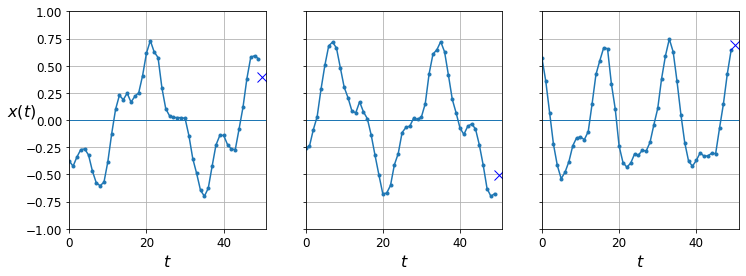

In [66]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))

<h1><center>Baseline Metrics</center></h1>

- Before we start using RNNs, it is often a good idea to have a few baseline metrics, or else we may end up thinking our model works great when in fact it is doing worse than basic models.

- For example, the simplest approach is to predict the last value in each series. This is called **naive forecasting**, and it is sometimes surprisingly difficult to outperform. In this case, it gives us a mean squared error of about 0.020:

In [67]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

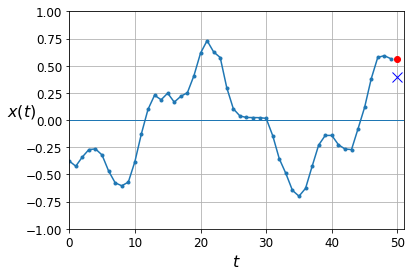

In [68]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

<h1><center>Using A Fully Connected Network</center></h1>

- Another simple approach is to use a fully connected network. Since it expects a flat list of features for each input, we need to add a Flatten layer.

- Let’s just use a simple Linear Regression model so that each prediction will be a linear combination of the values in the time series:

In [69]:
np.random.seed(42)
tf.random.set_seed(42)

In [70]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 0s 1ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 900us/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 882us/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 914us/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 960us/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 871us/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 878us/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 893us/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 869us/step - loss: 0.0061 - 

In [71]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 642us/step - loss: 0.0042


0.004168085753917694

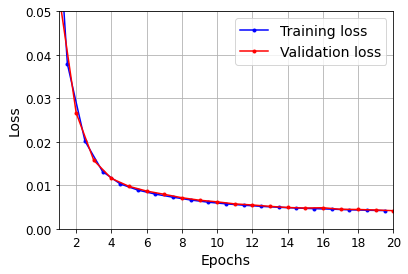

In [72]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])

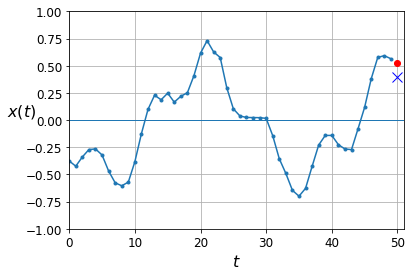

In [73]:
# And the prediction!
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

<h1><center>Simple RNN</center></h1>

- The following code is the simplest RNN you can build. It just contains a single layer, with a single neuron, as we saw in Figure 15-1.

- We do not need to specify the length of the input sequences (unlike in the previous model), since a recurrent neural network can process any number of time steps, this is why we set the first input dimension to None.

- By default, the SimpleRNN layer uses the hyperbolic tangent activation function.

- It works exactly as we saw earlier: the initial state $h_{(init)}$ is set to 0, and it is passed to a single recurrent neuron, along with the value of the first time step, $x_{(0)}$.

- The neuron computes a weighted sum of these values and applies the hyperbolic tangent activation function to the result, and this gives the first output, $y_0$.

- In a simple RNN, this output is also the new state $h_0$.

- This new state is passed to the same recurrent neuron along with the next input value, $x_{(1)}$, and the process is repeated until the last time step. Then the layer just outputs the last value, $y_{49}$.

- All of this is performed simultaneously for every time series.

In [74]:
np.random.seed(42)
tf.random.set_seed(42)

In [75]:
# Let’s see if we can beat the fully connected network with a simple RNN:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [76]:
optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0116 - val_lo

In [77]:
# Better than the naive approach but not better than the fully connected NN, because it's too simple!
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0109


0.010881561785936356

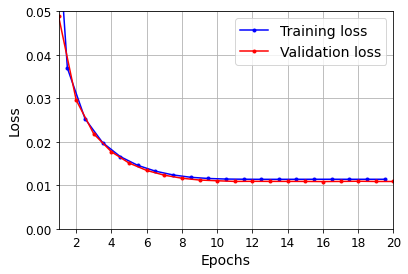

In [78]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])

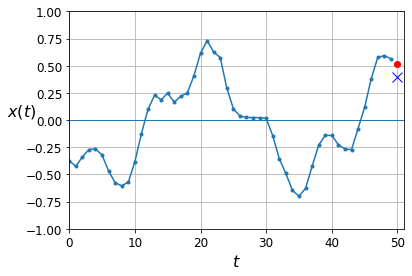

In [79]:
# And the prediction!
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

<h1><center>Analysis of Simple RNN</center></h1>

- So simple RNN is better than the naive approach but it does not beat a simple linear model. Note that for each neuron, a linear model has one parameter per input and per time step, plus a bias term (in the simple linear model we used, that’s a total of 51 parameters).


- In contrast, for each recurrent neuron in a simple RNN, there is just one parameter per input and per hidden state dimension (in a simple RNN, that’s just the number of recurrent neurons in the layer), plus a bias term. In this simple RNN, that’s a total of just three parameters.


- Apparently our simple RNN was too simple to get good performance. So more recurrent layers might be needed!

<h1><center>Trend and Seasonality</center></h1>

- There are many other models to forecast time series, such as weighted moving average models or autoregressive integrated moving average (ARIMA) models.


- Some of them require you to first remove the **trend** and **seasonality**.


- For example, if you are studying the number of active users on your website, and it is growing by 10% every month, you would have to remove this trend from the time series.


- Once the model is trained and starts making predictions, you would have to add the trend back to get the final predictions.

<h1><center>Trend and Seasonality Cont.</center></h1>

- Similarly, if you are trying to predict the amount of sunscreen lotion sold every month, you will probably observe strong **seasonality**: since it sells well every summer, a similar pattern will be repeated every year. 


- You would have to remove this **seasonality** from the time series, for example by computing the difference between the value at each time step and the value one year earlier - this technique is called **differencing**.


- Again, after the model is trained and makes predictions, you would have to add the seasonal pattern back to get the final predictions.


- When using RNNs, it is generally not necessary to do all this, but it may improve performance in some cases, since the model will not have to learn the **trend** or the **seasonality**.

<h1><center>Deep RNN</center></h1>

- It is quite common to stack multiple layers of cells, as shown in Figure 15-7. This gives you a **deep RNN**.

<center><img src="img/fig-15-7.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Implementing Deep RNN</center></h1>

- Implementing a **deep RNN** with `tf.keras` is quite simple: just stack recurrent layers.

- In this example, we use three `SimpleRNN` layers but we could add any other type of recurrent layer, such as an **LSTM** layer or a **GRU** layer, (which we will discuss shortly):

In [80]:
np.random.seed(42)
tf.random.set_seed(42)

In [81]:
''' Make sure to set return_sequences=True for all recurrent layers
(except the last one, if you only care about the last output).
If you don’t, they will output a 2D array (containing only the output of the last time step)
instead of a 3D array (containing outputs for all time steps),
and the next recurrent layer will complain that you are not feeding it sequences in the expected 3D format. '''
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

In [82]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0035 - val_lo

In [83]:
# We finally managed to beat the linear model!
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 8ms/step - loss: 0.0029


0.0029105604626238346

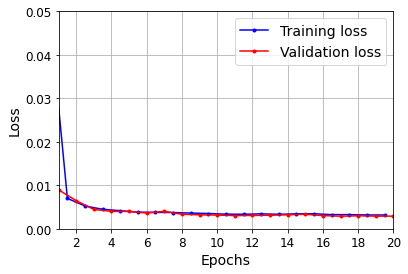

In [84]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])

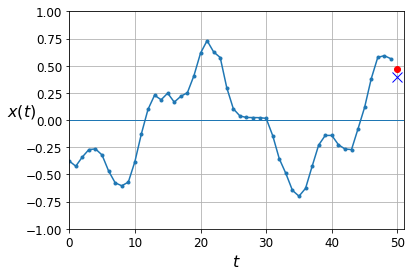

In [85]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

<h1><center>Another Version of Deep RNN</center></h1>

- Note that the last layer is not ideal: it must have a single unit because we want to forecast a univariate time series, and this means we must have a single output value per time step.

- However, having a single unit means that the hidden state is just a single number.

- That’s really not much, and it’s probably not that useful; presumably, the RNN will mostly use the hidden states of the other recurrent layers to carry over all the information it needs from time step to time step, and it will not use the final layer’s hidden state very much.

- Moreover, since a `SimpleRNN` layer uses the tanh activation function by default, the predicted values must lie within the range –1 to 1.

- But what if you want to use another activation function? For both these reasons, it might be preferable to replace the output layer with a Dense layer: it would run slightly faster, the accuracy would be roughly the same, and it would allow us to choose any output activation function we want.

- If you make this change, also make sure to remove `return_sequences=True` from the second (now last) recurrent layer:

In [86]:
np.random.seed(42)
tf.random.set_seed(42)

In [87]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

In [88]:
'''If you train this model, you will see that it converges faster and performs just as well.
Plus, you could change the output activation function if you wanted.'''
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0030 - val_lo

In [89]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 7ms/step - loss: 0.0026


0.002623624401167035

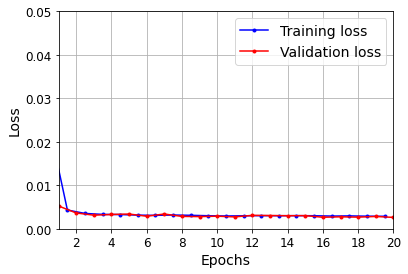

In [90]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])

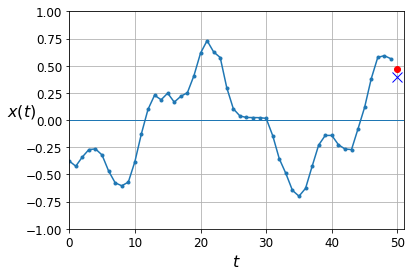

In [91]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

<h1><center>Forecasting Several Steps Ahead - 1st Option</center></h1>

- So far we have only predicted the value at the next time step, but we could just as easily have predicted the value several steps ahead by changing the targets appropriately (e.g., to predict 10 steps ahead, just change the targets to be the value 10 steps head instead of 1 step ahead). But what if we want to predict the next 10 values?

- The first option is to use the model we already trained, make it predict the next value, then add that value to the inputs (acting as if this predicted value had actually occurred), and use the model again to predict the following value, and so on, as in the following code:

In [92]:
np.random.seed(43) # not 42, as it would give the first series in the train set

In [93]:
# Predicting one at a time
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)
Y_pred = X[:, n_steps:]

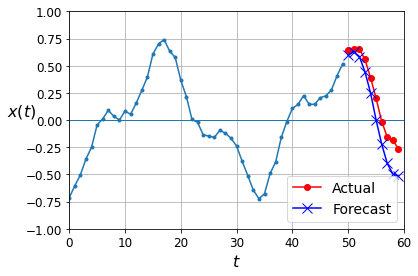

In [94]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)

<h1><center>Forecasting Several Steps Ahead - 1st Option</center></h1>

- As you might expect, the prediction for the next step will usually be more accurate than the predictions for later time steps, since the errors might accumulate (as you can see in Figure 15-8).

<center><img src="img/fig-15-8.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>1st Option Approach Evaluation</center></h1>

- If you evaluate this approach on the validation set, you will find an MSE of about 0.027. This is much higher than the previous models, but it’s also a much harder task, so the comparison doesn’t mean much.


- It’s much more meaningful to compare this performance with naive predictions (just forecasting that the time series will remain constant for 10 time steps) or with a simple linear model.


- The naive approach is terrible (it gives an MSE of about 0.223), but the linear model gives an MSE of about 0.0187: it’s much better than using our RNN to forecast the future one step at a time, and also much faster to train and run. Still, if you only want to forecast a few time steps ahead, on more complex tasks, this approach may work well.

In [95]:
np.random.seed(42)

In [96]:
# Now let's use this model to predict the next 10 values.
# We first need to regenerate the sequences with 9 more time steps.
# We need to change the targets to be vectors containing the next 10 values:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [97]:
# Now let's predict the next 10 values one by one:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]
Y_pred.shape

(2000, 10)

In [99]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.027510803

In [100]:
# Let's compare this performance with some baselines: naive predictions and a simple linear model:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848

In [101]:
np.random.seed(42)

In [102]:
# Simple linear model
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 0s 1ms/step - loss: 0.1202 - val_loss: 0.0634
Epoch 2/20
219/219 [==============================] - 0s 931us/step - loss: 0.0521 - val_loss: 0.0443
Epoch 3/20
219/219 [==============================] - 0s 930us/step - loss: 0.0400 - val_loss: 0.0360
Epoch 4/20
219/219 [==============================] - 0s 942us/step - loss: 0.0337 - val_loss: 0.0312
Epoch 5/20
219/219 [==============================] - 0s 944us/step - loss: 0.0299 - val_loss: 0.0281
Epoch 6/20
219/219 [==============================] - 0s 954us/step - loss: 0.0272 - val_loss: 0.0262
Epoch 7/20
219/219 [==============================] - 0s 961us/step - loss: 0.0255 - val_loss: 0.0246
Epoch 8/20
219/219 [==============================] - 0s 958us/step - loss: 0.0243 - val_loss: 0.0235
Epoch 9/20
219/219 [==============================] - 0s 943us/step - loss: 0.0233 - val_loss: 0.0228
Epoch 10/20
219/219 [==============================] - 0s 982us/step - loss: 0.0226 

<h1><center>Forecasting Several Steps Ahead - 2nd Option</center></h1>

- The second option is to train an RNN to predict all 10 next values at once.

- We can still use a sequence-to-vector model, but it will output 10 values instead of 1.

- Now we just need the output layer to have 10 units instead of 1:

In [103]:
np.random.seed(42)
tf.random.set_seed(42)

In [104]:
# Now let's create an RNN that predicts all 10 next values at once:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

In [105]:
'''After training this model, you can predict the next 10 values at once very easily
This model works nicely: the MSE for the next 10 time steps is about 0.0085.
That’smuch better than the linear model.'''
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0110 - val_lo

In [106]:
np.random.seed(43)

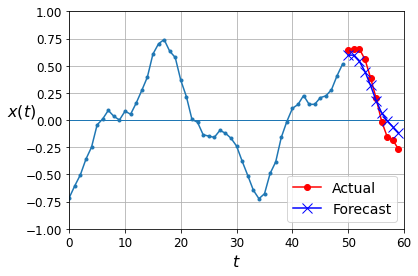

In [107]:
# After training this model, you can predict the next 10 values at once very easily.
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]
plot_multiple_forecasts(X_new, Y_new, Y_pred)

<h1><center>Forecasting Several Steps at Each Time Step</center></h1>

- Instead of training the model to forecast the next 10 values only at the very last time step, we can train it to forecast the next 10 values at each and every time step.

- In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN.

- The advantage of this technique is that the loss will contain a term for the output of the RNN at each and every time step, not just the output at the last time step.

- This means there will be many more error gradients flowing through the model, and they won’t have to flow only through time; they will also flow from the output of each time step.

- This will both stabilize and speed up training.

<h1><center>Forecasting Several Steps at Each Time Step</center></h1>

- To be clear, at time step 0 the model will output a vector containing the forecasts for time steps 1 to 10, then at time step 1 the model will forecast time steps 2 to 11, and so on.

- So each target must be a sequence of the same length as the input sequence, containing a 10-dimensional vector at each step. Let’s prepare these target sequences:

In [48]:
np.random.seed(42)

In [17]:
'''Now let's create an RNN that predicts the next 10 steps at each time step.
That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49,
it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on,
and finally it will forecast time steps 50 to 59 at the last time step.
Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.'''
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [50]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

<h1><center>Keras TimeDistributed</center></h1>

- To turn the model into a sequence-to-sequence model, we must set `return_sequences=True` in all recurrent layers (even the last one), and we must apply the output Dense layer at every time step.

- Keras offers a `TimeDistributed` layer for this very purpose: it wraps any layer (e.g., a Dense layer) and applies it at every time step of its input sequence.

- It does this efficiently, by reshaping the inputs so that each time step is treated as a separate instance i.e., it reshapes the inputs from [batch size, time steps, input dimensions] to [batch size × time steps, input dimensions]; in this example, the number of input dimensions is 20 because the previous `SimpleRNN` layer has 20 units, then it runs the Dense layer, and finally it reshapes the outputs back to sequences i.e., it reshapes the outputs from [batch size × time steps, output dimensions] to [batch size, time steps, output dimensions]; in this example the number of output dimensions is 10, since the Dense layer has 10 units.

- Here is the updated model:

In [51]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

<h1><center>Last Time Step MSE</center></h1>

- All outputs are needed during training, but only the output at the last time step is useful for predictions and for evaluation.

- So although we will rely on the MSE over all the outputs for training, we will use a custom metric for evaluation, to only compute the MSE over the output at the last time step:

In [52]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0351 - val_last_time_step_mse: 0.0243
Epoch 3/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0326 - last_time_step_mse: 0.0213 - val_loss: 0.0299 - val_last_time_step_mse: 0.0184
Epoch 4/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0291 - last_time_step_mse: 0.0177 - val_loss: 0.0273 - val_last_time_step_mse: 0.0156
Epoch 5/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0273 - last_time_step_mse: 0.0156 - val_loss: 0.0256 - val_last_time_step_mse: 0.0142
Epoch 6/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0250 - last_time_step_mse: 0.0123 - val_loss: 0.0249 - val_last_time_step_mse: 0.0119
Epoch 7/20
219/219 [==

In [53]:
np.random.seed(43)

In [54]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

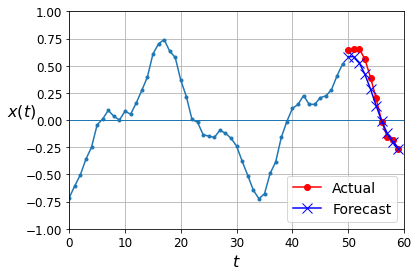

In [55]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)

<h1><center>Handling Long Sequences</center></h1>

- Simple RNNs can be quite good at forecasting time series or handling other kinds of sequences, but they do not perform as well on long time series or sequences.


- To train an RNN on long sequences, we must run it over many time steps, making the unrolled RNN a very deep network.


- Just like any deep neural network it may suffer from the **unstable gradients** problem: it may take forever to train, or training may be unstable.


- Moreover, when an RNN processes a long sequence, it will gradually forget the first inputs in the sequence.


- Let’s look at both these problems, starting with the **unstable gradients** problem.

<h1><center>Fighting the Unstable Gradients Problem</center></h1>

- Many of the tricks we used in deep nets to alleviate the unstable gradients problem can also be used for RNNs: good parameter initialization, faster optimizers, dropout, and so on.


- However, nonsaturating activation functions (e.g., ReLU) may not help as much here; in fact, they may actually lead the RNN to be even more unstable during training. Why?

    - Suppose Gradient Descent updates the weights in a way that increases the outputs slightly at the first time step.

    - Because the same weights are used at every time step, the outputs at the second time step may also be slightly increased, and those at the third, and so on until the outputs explode—and a nonsaturating activation function does not prevent that. You can reduce this risk by using a smaller learning rate, but you can also simply use a saturating activation function like the hyperbolic tangent (this explains why it is the default).


- In much the same way, the gradients themselves can explode. If you notice that training is unstable, you may want to monitor the size of the gradients (e.g., using TensorBoard) and perhaps use **Gradient Clipping**.

<h1><center>Layer Normalization</center></h1>


- Batch Normalization cannot be used as efficiently with RNNs as with deep feedforward nets. In fact, you cannot use it between time steps, only between recurrent layers.


- Another form of normalization often works better with RNNs: **Layer Normalization**.


- This idea was introduced by Jimmy Lei Ba et al. in a 2016 paper: it is very similar to Batch Normalization, but instead of normalizing across the batch dimension, it normalizes across the features dimension.


- One advantage is that it can compute the required statistics on the fly, at each time step, independently for each instance.


- This also means that it behaves the same way during training and testing (as opposed to BN), and it does not need to use exponential moving averages to estimate the feature statistics across all instances in the training set.


- Like BN, **Layer Normalization** learns a scale and an offset parameter for each input. In an RNN, it is typically used right after the linear combination of the inputs and the hidden states.

<h1><center>Layer Normalization Cont.</center></h1>

- Let’s use `tf.keras` to implement Layer Normalization within a simple memory cell.

- For this, we need to define a custom memory cell. It is just like a regular layer, except its `call()` method takes two arguments: the inputs at the current time step and the hidden states from the previous time step.

- Note that the `states` argument is a list containing one or more tensors.

- In the case of a simple RNN cell it contains a single tensor equal to the outputs of the previous time step, but other cells may have multiple state tensors (e.g., an `LSTMCell` has a long-term state and a short-term state, as we will see shortly).

- A cell must also have a `state_size` attribute and an `output_size` attribute. In a simple RNN, both are simply equal to the number of units.

<h1><center>Layer Normalization in tf.keras</center></h1>

- The following code implements a custom memory cell which will behave like a `SimpleRNNCell`, except it will also apply **Layer Normalization** at each time step:

In [8]:
from tensorflow.keras.layers import LayerNormalization

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

''' The code is quite straightforward. Our LNSimpleRNNCell class inherits from the keras.layers.Layer class,
just like any custom layer.
The constructor takes the number of units and the desired activation function, and it sets the state_size and
output_size attributes, then creates a SimpleRNNCell with no activation function
(because we want to perform Layer Normalization after the linear operation but before the activation function).
Then the constructor creates the LayerNormalization layer, and finally it fetches the desired activation function.
The call() method starts by applying the simple RNN cell,
which computes a linear combination of the current inputs and the previous hidden states,
and it returns the result twice (indeed, in a SimpleRNNCell , the outputs are just equal to the hidden states: 
in other words, new_states[0] is equal to outputs , so we can safely ignore new_states in the rest of
the call() method). Next, the call() method applies Layer Normalization,
followed by the activation function. Finally, it returns the outputs twice (once as the outputs,
and once as the new hidden states). '''

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

In [19]:
''' To use this custom cell, all we need to do is create
a keras.layers.RNN layer, passing it a cell instance: '''

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

''' With these techniques, you can alleviate the unstable gradients problem and train an
RNN much more efficiently. '''

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

<h1><center>Tackling the Short-Term Memory Problem</center></h1>

- Due to the transformations that the data goes through when traversing an RNN, some information is lost at each time step.


- After a while, the RNN’s state contains virtually no trace of the first inputs.


- This can be a showstopper. Imagine Dory the fish trying to translate a long sentence; by the time she’s finished reading it, she has no clue how it started.


- To tackle this problem, various types of cells with long-term memory have been introduced. They have proven so successful that the basic cells are not used much anymore.


- Let’s first look at the most popular of these long-term memory cells: the **LSTM cell**.

<h1><center>LSTM Cell</center></h1>

- The **Long Short-Term Memory (LSTM) cell** was proposed in 1997 by Sepp Hochreiter and Jürgen Schmidhuber and gradually improved over the years by several researchers, such as Alex Graves, Haşim Sak, and Wojciech Zaremba.

- If you consider the **LSTM cell** as a black box, it can be used very much like a basic cell, except it will perform much better; training will converge faster, and it will detect long-term dependencies in the data.

<center><img src="img/fig-15-9.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

**Equation 15-3: LSTM computations**

$
\begin{split}
\mathbf{i}_{(t)}&=\sigma({\mathbf{W}_{xi}}^T \mathbf{x}_{(t)} + {\mathbf{W}_{hi}}^T \mathbf{h}_{(t-1)} + \mathbf{b}_i)\\
\mathbf{f}_{(t)}&=\sigma({\mathbf{W}_{xf}}^T \mathbf{x}_{(t)} + {\mathbf{W}_{hf}}^T \mathbf{h}_{(t-1)} + \mathbf{b}_f)\\
\mathbf{o}_{(t)}&=\sigma({\mathbf{W}_{xo}}^T \mathbf{x}_{(t)} + {\mathbf{W}_{ho}}^T \mathbf{h}_{(t-1)} + \mathbf{b}_o)\\
\mathbf{g}_{(t)}&=\operatorname{tanh}({\mathbf{W}_{xg}}^T \mathbf{x}_{(t)} + {\mathbf{W}_{hg}}^T \mathbf{h}_{(t-1)} + \mathbf{b}_g)\\
\mathbf{c}_{(t)}&=\mathbf{f}_{(t)} \otimes \mathbf{c}_{(t-1)} \, + \, \mathbf{i}_{(t)} \otimes \mathbf{g}_{(t)}\\
\mathbf{y}_{(t)}&=\mathbf{h}_{(t)} = \mathbf{o}_{(t)} \otimes \operatorname{tanh}(\mathbf{c}_{(t)})
\end{split}
$

<h1><center>LSTM In Keras</center></h1>

- In Keras, you can simply use the `LSTM` layer instead of the `SimpleRNN` layer:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

<h1><center>GRU Cell</center></h1>

- There are many other variants of the LSTM cell. One particularly popular variant is the GRU cell.

- The GRU cell is a simplified version of the LSTM cell, and it seems to perform just as well which explains its growing popularity.

<center><img src="img/fig-15-10.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>WaveNet Architecture</center></h1>

- In a 2016 paper, Aaron van den Oord and other DeepMind researchers introduced an architecture called WaveNet.

- They stacked 1D convolutional layers, doubling the dilation rate (how spread apart each neuron’s inputs are) at every layer: the first convolutional layer gets a glimpse of just two time steps at a time, while the next one sees four time steps (its receptive field is four time steps long), the next one sees eight time steps, and so on (see Figure 15-11).

- This way, the lower layers learn short-term patterns, while the higher layers learn long-term patterns.

- Thanks to the doubling dilation rate, the network can process extremely large sequences very efficiently.

<center><img src="img/fig-15-11.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>References</center></h1>

[1] Hands-On ML Textbook Edition-2 2019